In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
df = pd.read_csv('Fraud_check.csv')

In [3]:
df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


## Data Exploration 

In [4]:
df.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [5]:
df.isnull()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
595,False,False,False,False,False,False
596,False,False,False,False,False,False
597,False,False,False,False,False,False
598,False,False,False,False,False,False


## Descriptive Analysis

In [6]:
df.shape

(600, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.3+ KB


In [8]:
df[df.duplicated()].shape

(0, 6)

In [9]:
df[df.duplicated()]

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


In [10]:
df.describe()

,Taxable.Income,City.Population,Work.Experience
count,600.000000,600.000000,600.000000
mean,55208.375000,108747.368333,15.558333
std,26204.827597,49850.075134,8.842147
min,10003.000000,25779.000000,0.000000
25%,32871.500000,66966.750000,8.000000
50%,55074.500000,106493.500000,15.000000
75%,78611.750000,150114.250000,24.000000
max,99619.000000,199778.000000,30.000000


The features are not on the same scale. For example City.Population has a mean of 108747.36 while Work.Experience has a mean value of 15.55. Features should be on the same scale for algorithms such as logistic regression (gradient descent) to converge smoothly. Let's go ahead and check further.

## Feature Engineering

### Lets assume: taxable_income <= 30000 as “Risky=0” and others are “Good=1”

In [11]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['taxable_category'] = pd.cut(x = df1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
df1.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,taxable_category
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


In [12]:
categorical_features = df.describe(include=["object"]).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')

In [13]:
numerical_features = df.describe(include=['int64']).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

## Data Visualization

### Univariate Plot

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

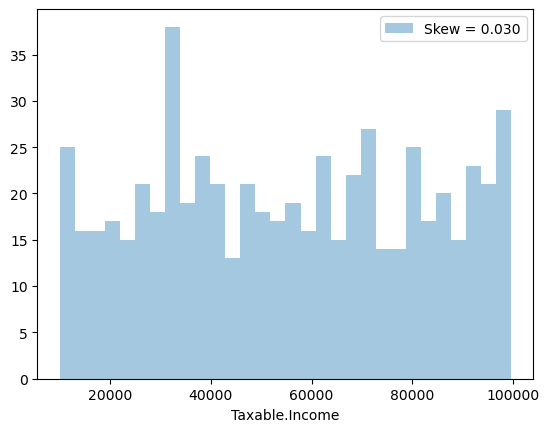

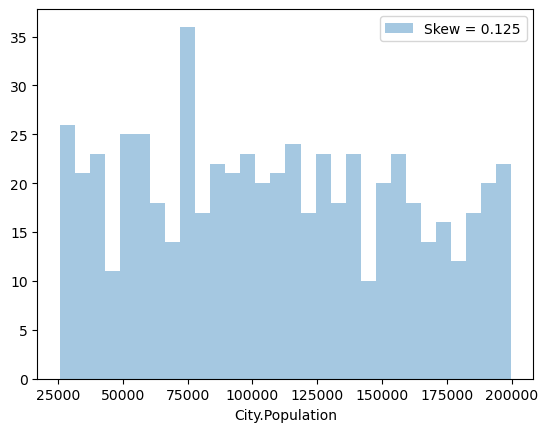

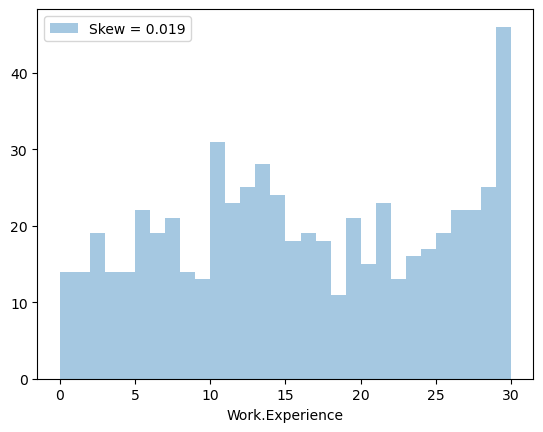

In [15]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

### None of the feature is normally distributed

In [16]:
from collections import Counter

In [17]:
def outlier_hunt(df):
    outlier_indices=[]
    for col in df.columns.tolist():
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3-Q1
        outlier_step = 1.5*IQR
        outlier_list_col = df[(df[col]< Q1 - outlier_step) | (df[col]>Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        outlier_indices = Counter(outlier_indices)
        multiple_outliers = list(k for k, v in outlier_indices.items() if v > 2)
        return multiple_outliers
print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features]))))
        

The dataset contains 0 observations with more than 2 outliers


### Lets plot the boxplots 

In [18]:
numerical_features


['Taxable.Income', 'City.Population', 'Work.Experience']

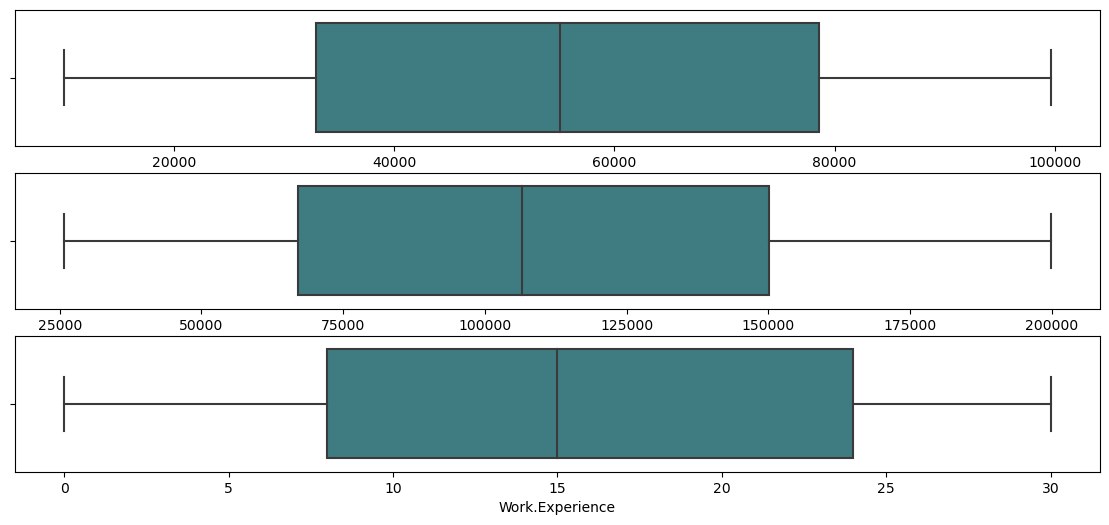

In [19]:
ot = df.copy()
fig,axes = plt.subplots(3,1,figsize=(14,6),sharex = False,sharey = False)
sns.boxplot(x='Taxable.Income' , data =ot,palette='crest',ax=axes[0])
sns.boxplot(x='City.Population' , data =ot,palette='crest',ax=axes[1])
sns.boxplot(x='Work.Experience',data=ot,palette='crest',ax=axes[2])
plt.show()

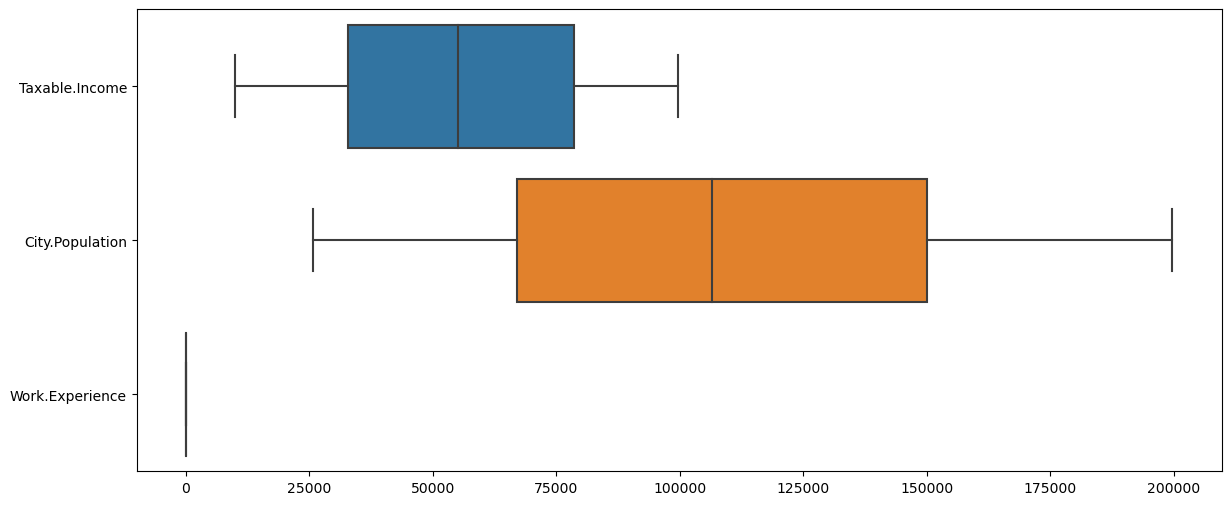

In [20]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df[numerical_features],orient='h');

#### Work.Experience has a mean that is much inferior to the other constituents as we already saw in the previous section.

### Multivariate Analysis

<Figure size 800x800 with 0 Axes>

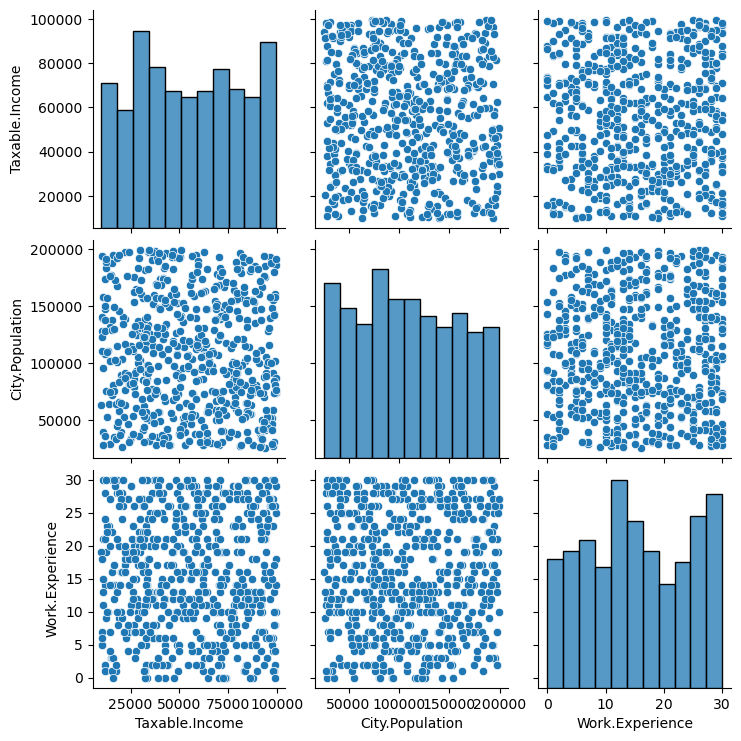

In [21]:
plt.figure(figsize=(8,8))
sns.pairplot(df,palette='coolwarm')
plt.show()

<Axes: >

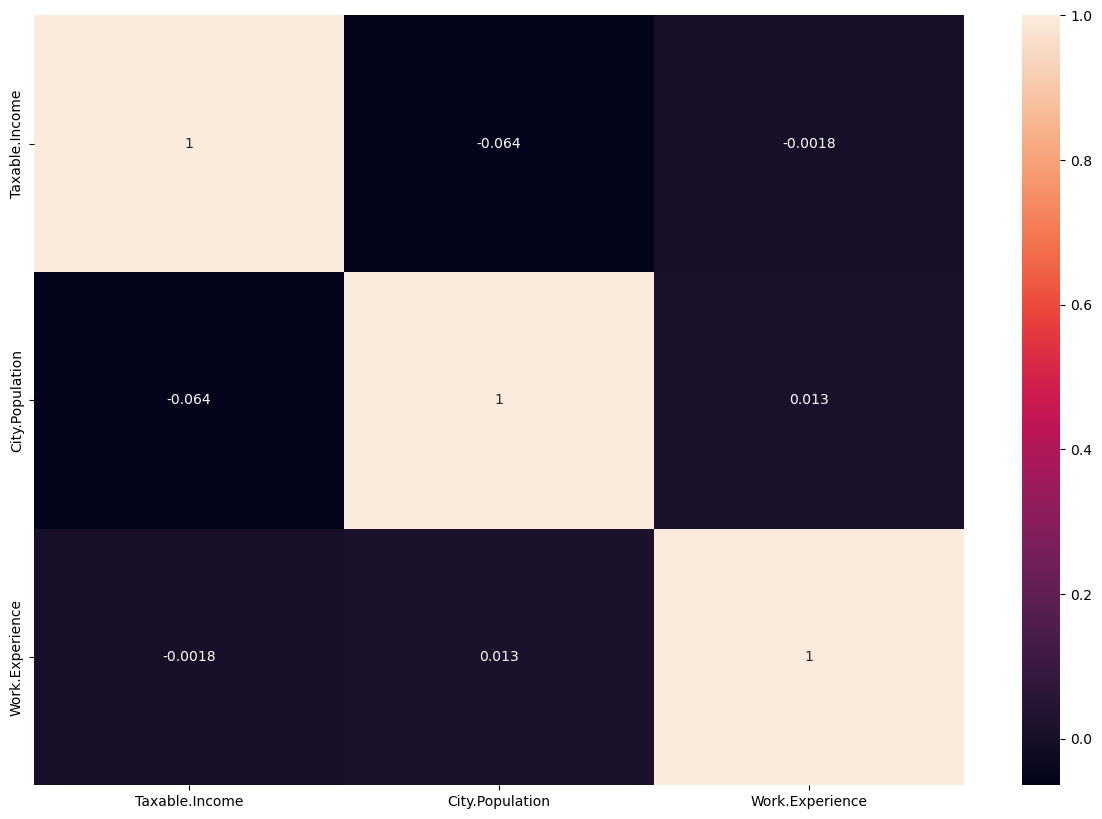

In [22]:
# Heat map
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')


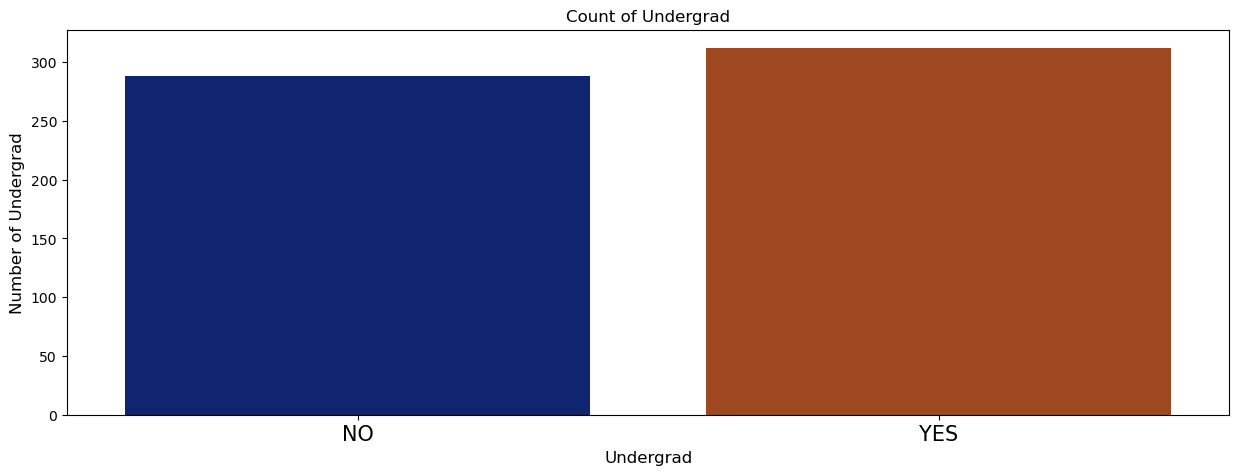

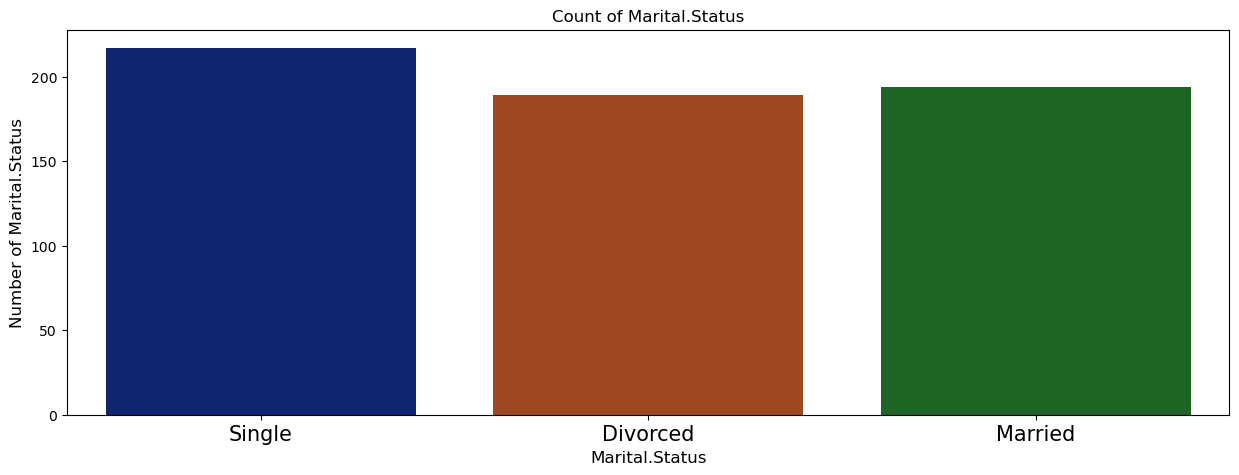

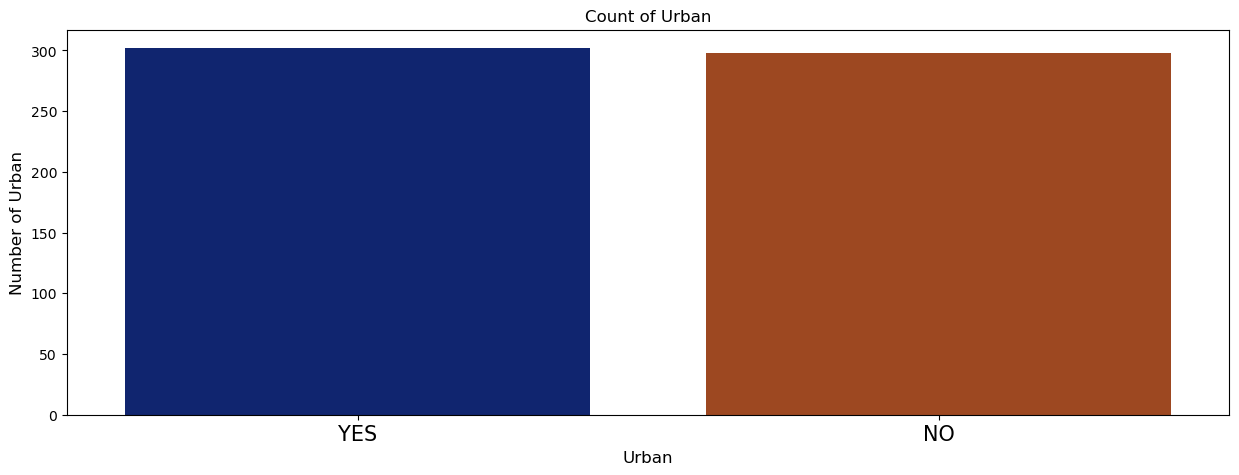

In [23]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = df[column].value_counts(ascending=True);
 
    #plt.subplot(1, len(categorical_features), idx+1)    
    plt.title("Count of "+ column)
    sns.countplot(data=df, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)
    
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

In [24]:
def factorplot(param):
    sns.factorplot(x = param, size = 7, aspect = 2, data = df, y= "Taxable.Income", palette = "dark")
    plt.xlabel("\n" + param)
    plt.ylabel("Sales\n")
    plt.show()

In [25]:
factorplot("Work.Experience")

AttributeError: module 'seaborn' has no attribute 'factorplot'

In [ ]:
sns.pairplot(data=df1, hue = 'taxable_category')

### Checking for Imbalanced or balanced dataset with regards to the Target

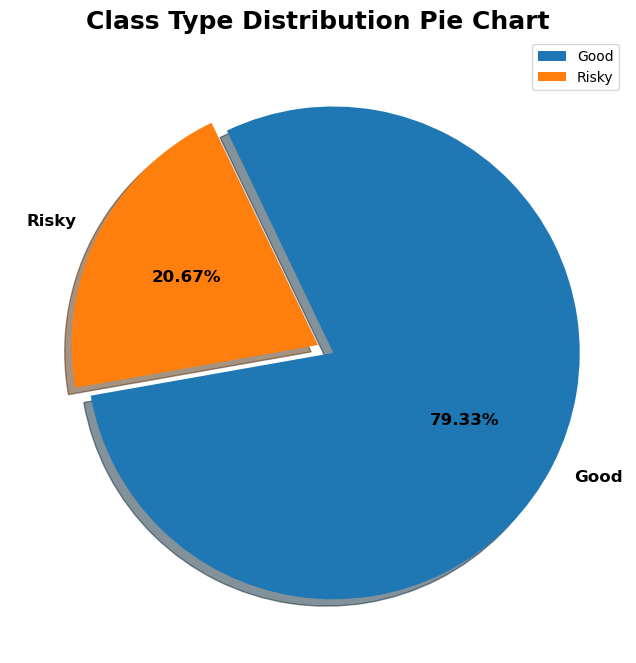

In [27]:
plt.figure(figsize = (12,8))
plt.pie(df1['taxable_category'].value_counts(),
       labels=df1.taxable_category.unique(),
       explode = [0.07,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'horizontal',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

### It is a imbalance data 
the class “Good” is called the majority class, and the much smaller in size “Risky” class is called the minority class.

In [28]:
countNotermdeposit = len(df1[df1['taxable_category'] == 'Good'])
counthavetermdeposit = len(df1[df1['taxable_category'] == 'Risky'])
print("Percentage of Customer doesn't have a term deposit: {:.2f}%".format((countNotermdeposit / (len(df1.taxable_category))*100)))
print("Percentage of Customer have a term deposit: {:.2f}%".format((counthavetermdeposit / (len(df1.taxable_category))*100)))

Percentage of Customer doesn't have a term deposit: 79.33%
Percentage of Customer have a term deposit: 20.67%


In [29]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

Text(0.5, 1.0, 'Risky or Good for Individual Taxable Income ')

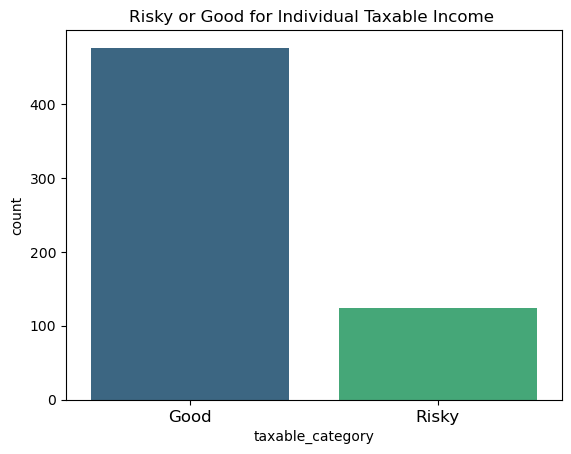

In [30]:
sns.countplot(x='taxable_category', data=df1, palette = 'viridis', 
              order=df1['taxable_category'].value_counts().index)
plt.xticks(fontsize = 12)
plt.title('Risky or Good for Individual Taxable Income ')

## Data Pre-Processing

In [31]:
data = df1.copy()
data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

In [33]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [34]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(data[col])
        data[col] = le.transform(data[col])
data.head()

,Undergrad,Marital_Status,City_Population,Work_Experience,Urban,taxable_category
0,0,2,50047,10,1,0
1,1,0,134075,18,1,0
2,0,1,160205,30,1,0
3,1,2,193264,15,1,0
4,0,1,27533,28,0,0


In [35]:
data.taxable_category.value_counts()

0    476
1    124
Name: taxable_category, dtype: int64

#### Data is Imbalanced 

## Test Train Split With Imbalanced Dataset

In [36]:
x = data.drop('taxable_category',axis=1)
y = data['taxable_category']

In [38]:
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV

In [39]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
# select rows
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]
# summarize train and test composition
    train, train1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test, test1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train, train1, test, test1))

>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13


In [40]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [41]:
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=333, 1=87, Test: 0=143, 1=37


In [42]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


##   Grid search using Stratified Kfold Splits on Imbalanced Dataset

In [43]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print(" ")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print(" ")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print(" ")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print(" ")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [47]:
from sklearn.tree import  DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

In [48]:
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(train_X, train_y)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(train_X, train_y)
print_score(tree_clf, train_X, train_y, test_X, test_y, train=True)
print_score(tree_clf, train_X, train_y, test_X, test_y, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:

Accuracy Score: 79.44%
 
CLASSIFICATION REPORT:
                    0      1  accuracy   macro avg  weighted avg
precision    0.794444    0.0  0.794444    0.397222      0.631142
recall       1.000000    0.0  0.794444    0.500000      0.794444
f1-score     0.885449    0.0  0.794444    0.442724      0.703440
support    429.000000  111.0  0.794444  540.000000    540.000000
 
Confusion Matrix: 
 [[429   0]
 [111   0]]

Test Result:

Accuracy Score: 78.33%
 
CLASSIFICATION REPORT:
                   0     1  accuracy  macro avg  weighted avg
precision   0.783333   0.0  0.783333   0.391667      0.613611
recall      1.000000   0.0  0.783333   0.500000      0.783333
f1-score    0.878505   0.0  0.783333   0.439252      0.688162
support    47.000000  13.0  0.783333  60.000000     60.000000
 
Conf

In [49]:
# Get score for different values of n
decision_tree = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

results = cross_val_score(decision_tree, train_X, train_y, cv=skf)
print(results.mean())

0.6203703703703703


In [50]:
param_dict = {
    "criterion":["gini","entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=skf,
                   verbose=1,
                   n_jobs=6)

grid.fit(train_X,train_y)

model = grid.best_estimator_

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


In [51]:
grid.best_score_

0.7944444444444444

In [52]:
predict_output = model.predict(test_X)
accuracy_test = accuracy_score(test_y,predict_output)
accuracy_test

0.7833333333333333

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        47
           1       0.00      0.00      0.00        13

    accuracy                           0.78        60
   macro avg       0.39      0.50      0.44        60
weighted avg       0.61      0.78      0.69        60



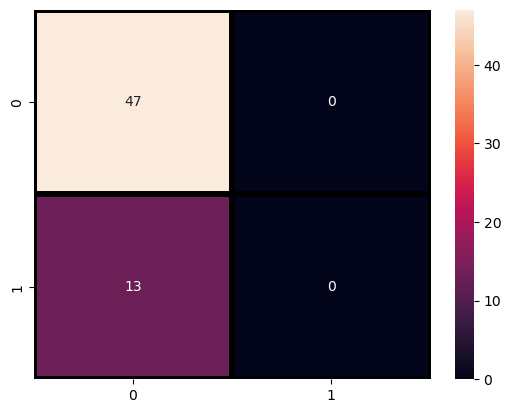

In [53]:
sns.heatmap(confusion_matrix(test_y, predict_output),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(test_y,predict_output))

### Grid search using Train Test Splits Stratifying Target feature on Imbalanced Dataset

In [54]:
params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 20))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:

Accuracy Score: 79.29%
 
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.792857   0.0  0.792857    0.396429      0.628622
recall       1.000000   0.0  0.792857    0.500000      0.792857
f1-score     0.884462   0.0  0.792857    0.442231      0.701252
support    333.000000  87.0  0.792857  420.000000    420.000000
 
Confusion Matrix: 
 [[333   0]
 [ 87   0]]

Test Result:

Accuracy Score: 79.44%
 
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.794444   0.0  0.794444    0.397222      0.631142
recall       1.000000   0.0  0.794444    0.500000      0.794444
f1-score     0.885449   0.0  0.794444    0.442724      0.703440
support    143.000000  37.0  0.794444  180.000000    180.000000
 

In [55]:
# Get score for different values of n
decision_tree = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

results = cross_val_score(decision_tree, x_train, y_train, cv=skf)
print(results.mean())

0.6357142857142857


In [56]:
param_dict = {
    "criterion":["gini","entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=skf,
                   verbose=1,
                   n_jobs=6)

grid.fit(x_train,y_train)

model = grid.best_estimator_

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


In [57]:
grid.best_score_

0.7928571428571429

In [58]:
predict_output = model.predict(x_test)
accuracy_test = accuracy_score(y_test,predict_output)
accuracy_test

0.7944444444444444

              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180



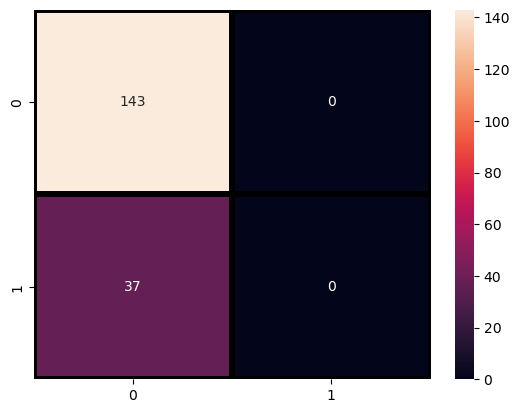

In [59]:
sns.heatmap(confusion_matrix(y_test, predict_output),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(y_test,predict_output))

## Handling imbalance data using SMOTE based techniques

In [62]:
x = data.drop(['taxable_category'], axis=1)
y = data['taxable_category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [63]:
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

>Train: 0=333, 1=87, Test: 0=143, 1=37
Shape of X_train:  (420, 5)
Shape of X_test:  (180, 5)
Shape of y_train:  (420,)
Shape of y_test (180,)


In [65]:
from imblearn.over_sampling import SMOTE

In [66]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


In [67]:
model_params = {
    'decision_tree' :{
        'model' :  DecisionTreeClassifier(),
        'params' : {
             'max_depth': [i for i in range(5,16,2)],
             'min_samples_split': [2, 5, 10, 15, 20, 50, 100],
             'min_samples_leaf': [1, 2, 5],
             'criterion': ['gini', 'entropy'],
             'max_features': ['log2', 'sqrt', 'auto']
        }
        
    }
    
}

In [72]:
from imblearn.combine import SMOTETomek, SMOTEENN

In [73]:
counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=0)
x_train_smtom, y_train_smtom = smtom.fit_resample(x, y)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 476, 1: 124})
After Counter({0: 354, 1: 354})


In [74]:
x_train,x_test,y_train,y_test = train_test_split(x_train_smtom,y_train_smtom,test_size=0.3,random_state=0, stratify=y_train_smtom)

counter = Counter(y_train_smtom)
print('Before',counter)
counter = Counter(y_train)
print('After',counter)
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Before Counter({0: 354, 1: 354})
After Counter({1: 248, 0: 247})
Shape of X_train:  (495, 5)
Shape of X_test:  (213, 5)
Shape of y_train:  (495,)
Shape of y_test (213,)


## Pruning

In [75]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

params = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 6))), 
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 6)), 
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 72.53%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.796791    0.681818  0.725253    0.739305      0.739189
recall       0.603239    0.846774  0.725253    0.725007      0.725253
f1-score     0.686636    0.755396  0.725253    0.721016      0.721085
support    247.000000  248.000000  0.725253  495.000000    495.000000
_______________________________________________
Confusion Matrix: 
 [[149  98]
 [ 38 210]]

Test Result:
Accuracy Score: 63.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.745763    0.590909  0.633803    0.668336      0.668699
recall       

### This is a balanced state of training and testing accuracy are close to each other where there is no overfitting or underfitting yet we can do better than this, let's try post pruning technique using Alpha Values

##  Building Decision Tree Classifier using Entropy Criteria with Alpha values Post Pruning

In [76]:
model_entropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
model_entropy.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [78]:
from sklearn import tree

In [84]:
model_gini = DecisionTreeClassifier(criterion='gini', random_state=0)
model_gini.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

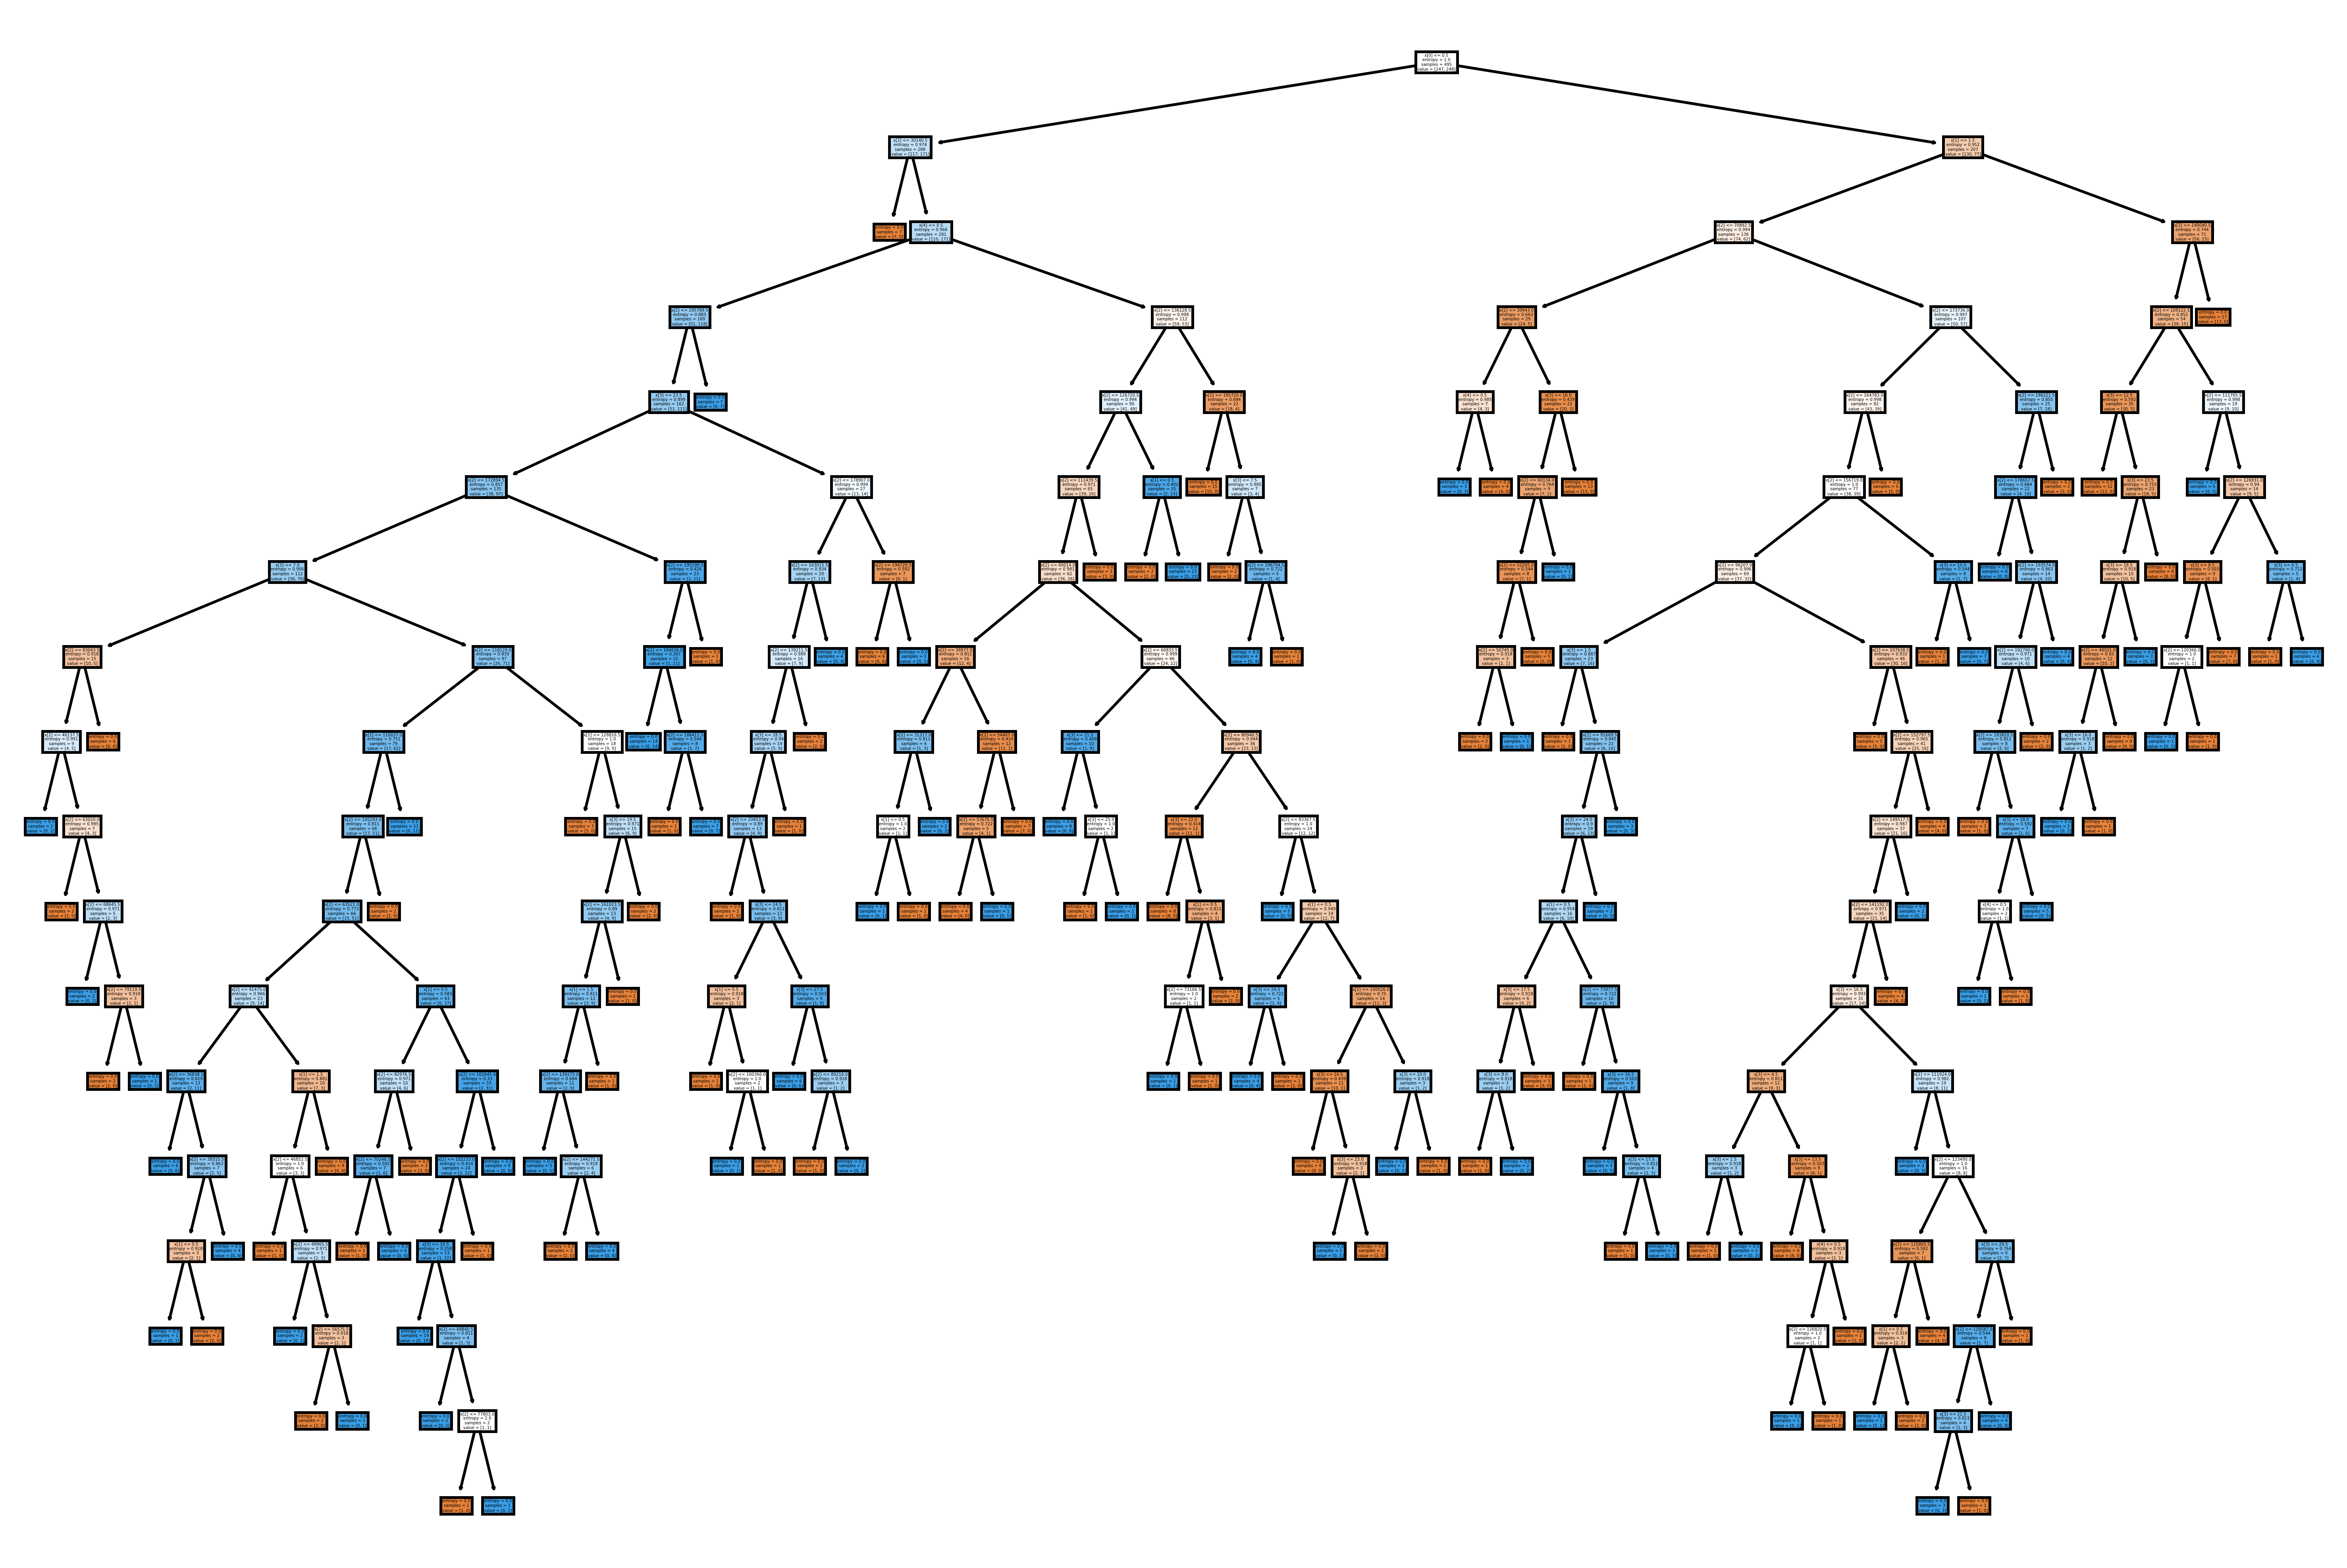

In [79]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_entropy,filled=True)
plt.show()

In [86]:
#Predicting on test data
preds = model_gini.predict(x_test) # predicting on test data set 
pd.Series(preds).value_counts() # getting the count of each category 

1    124
0     89
dtype: int64

In [87]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0,0,1
taxable_category,,
0,64,43
1,25,81


In [88]:
# Accuracy 
np.mean(preds==y_test)

0.6807511737089202

In [89]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.72      0.60      0.65       107
           1       0.65      0.76      0.70       106

    accuracy                           0.68       213
   macro avg       0.69      0.68      0.68       213
weighted avg       0.69      0.68      0.68       213



In [90]:
path = model_gini.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [91]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.023932351623392523


In [92]:
ccp_alphas

array([0.        , 0.00119716, 0.0013468 , 0.00151515, 0.00151821,
       0.00157127, 0.00161616, 0.00161616, 0.0016835 , 0.00176768,
       0.00176768, 0.00176768, 0.00179574, 0.00179574, 0.00181818,
       0.00181818, 0.00181818, 0.00183655, 0.00185346, 0.00186147,
       0.00190542, 0.0020202 , 0.0020202 , 0.00212121, 0.00217172,
       0.0022792 , 0.00229568, 0.00242424, 0.00242424, 0.0026936 ,
       0.00269841, 0.00280584, 0.00282279, 0.00287351, 0.00301194,
       0.00323232, 0.00323232, 0.00323232, 0.00323232, 0.00329966,
       0.0034188 , 0.0034632 , 0.00346801, 0.00347222, 0.00353535,
       0.0036556 , 0.00369408, 0.00404033, 0.0040404 , 0.00449995,
       0.00468636, 0.00538827, 0.00543903, 0.00570461, 0.00591554,
       0.00600582, 0.00629673, 0.0067583 , 0.00743434, 0.01141341,
       0.01162234, 0.01368911, 0.02393235])

#### Choosing the best value of cc_alpha where the testing and training accuracy are almost same or near or closer to each other

In [93]:
clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=0.00600582)
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00600582, random_state=0)

In [94]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.7414141414141414 
Testing Accuracy 0.6619718309859155


              precision    recall  f1-score   support

           0       0.68      0.61      0.64       107
           1       0.64      0.72      0.68       106

    accuracy                           0.66       213
   macro avg       0.66      0.66      0.66       213
weighted avg       0.66      0.66      0.66       213



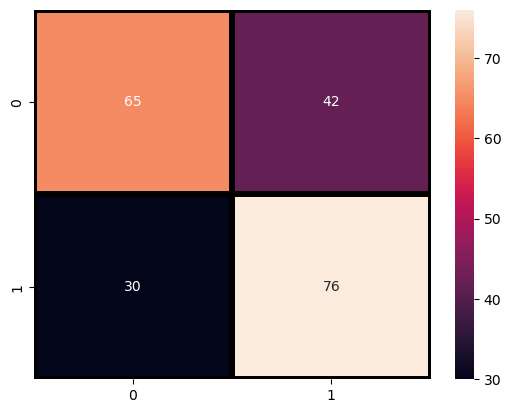

In [96]:
sns.heatmap(confusion_matrix(y_test, pred_test),annot=True,fmt = "d",linecolor="k",linewidths=3)
print(classification_report(y_test,pred_test))

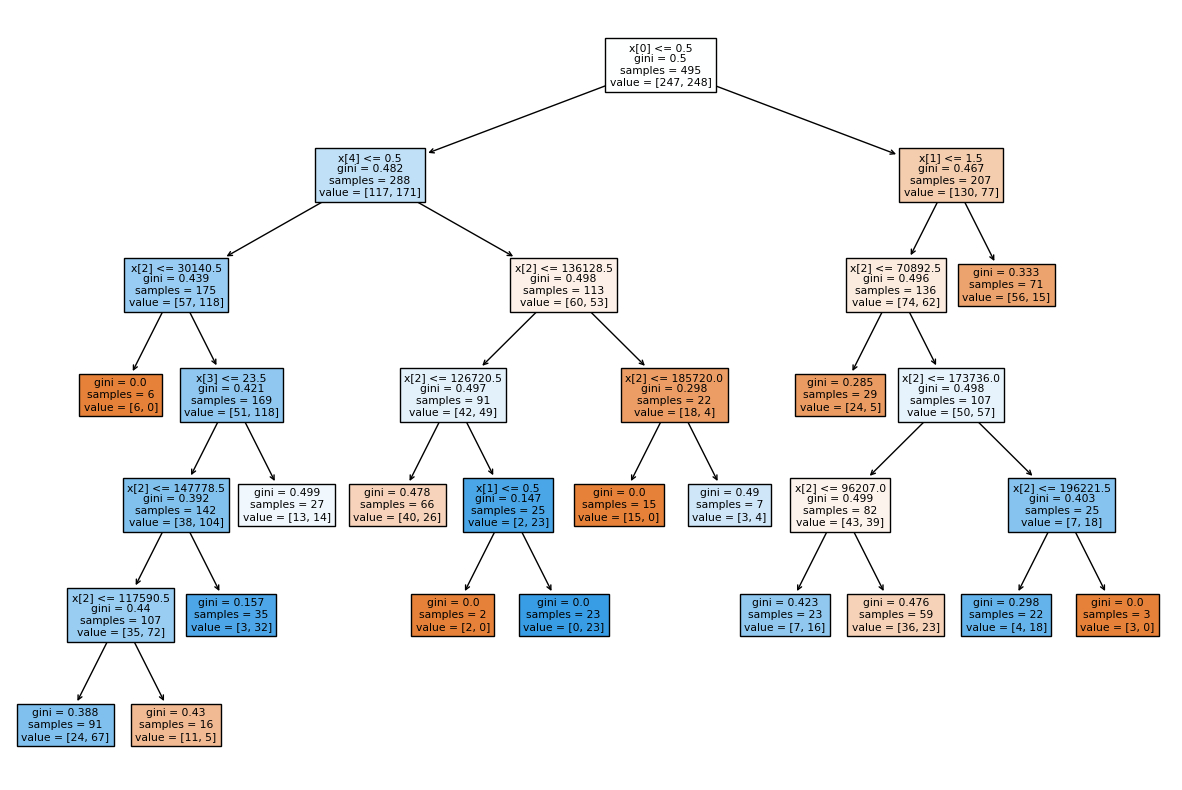

In [97]:
plt.figure(figsize=(15,10))
tree.plot_tree(clf,filled=True)
plt.show()